# Fig 4 - Mutation map

In preparation to the execution of this notebook please make sure that you have executed all the commands noted in the README.md file in the repository root. Additionally for this notebook to work you will have to run `conda env create -f fig4.yml` prior to starting jupyter. After successful generation of the conda environment please run `source activate kipoi-fig4-mutationmap` prior to launching this notebook!

In [1]:
import os
from collections import OrderedDict
ROOT = "../../"
os.chdir(ROOT)
VCF_PATH = "data/raw/mutation_map/ClinVar/sample.vcf"
HG19_PATH = "data/raw/dataloader_files/shared/hg19.fa"

Now we can generate the vcf that we will use to query the variants:

In [2]:
# First write the VCF file defining the mutation of interest:
with open(VCF_PATH, "w") as ofh:
    ofh.write("""##fileformat=VCFv4.0
##contig=<ID=chr11,length=135006516>
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO
chr11	5246970	chr11:5246970:A:C	A	C	.	.	.""")

Now actually run the calculation of the mutation map. To save time I have pre-computed the results for lsgkm-SVM because it takes about 35min to calculate the mutation map, feel free to delete `data/processed/mutation_map/computed/lsgkm.hdf5` and run the next cell, but it will take a while to run.

In [4]:
MODEL_NAME_DICT = OrderedDict([('pwm', 'pwm_HOCOMOCO/human/GATA1'), ('lsgkm', 'lsgkm-SVM/Tfbs/Gata1/Pbde/Sydh_Ucd'),
('deepbind', 'DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1'), ('deepsea','DeepSEA/variantEffects')])
MODEL_OUTPUT_DICT = {'pwm':'0',
  'lsgkm': '0',
  'deepbind':'0',
  'deepsea':'K562_GATA-1_None_622'}

output_path = "data/processed/mutation_map/computed/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for model_label in MODEL_NAME_DICT:
    print(model_label)
    model_name = MODEL_NAME_DICT[model_label]
    dataloader_args = '{\'fasta_file\':\''+HG19_PATH+'\'}'
    regions_file = VCF_PATH
    out_hdf5 = output_path + "{model}.hdf5".format(model=model_label)
    seqlen_param = "--seq_length  101 " if "pwm" in model_label or "lsgkm" in model_label else ""
    command = """kipoi veff create_mutation_map {model_name} --source kipoi --batch_size 32 \
    --dataloader_args \"{dataloader_args}\" --regions_file \
    {regions_file} --output {out_hdf5} {seqlen_param}""".format(model_name=model_name,
                                                               dataloader_args=dataloader_args,
                                                              regions_file=regions_file,
                                                               out_hdf5= out_hdf5,
                                                              seqlen_param = seqlen_param)
    if not os.path.exists(out_hdf5):
        os.system(command)

pwm
lsgkm
deepbind
deepsea


After producing the hdf5 output files we can now load the generated data into a mutation map plotter:

In [5]:
from kipoi_veff.mutation_map import MutationMapPlotter
model_mms = OrderedDict()

for model_label in MODEL_NAME_DICT:
    hdf5_file = "data/processed/mutation_map/computed/{model}.hdf5".format(model = model_label)
    if os.path.exists(hdf5_file):
        model_mms[model_label] = MutationMapPlotter(fname=hdf5_file)

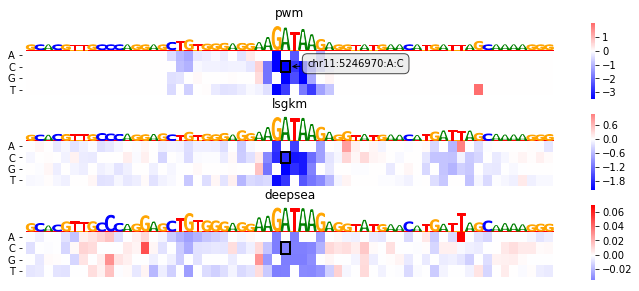

In [6]:
# Mutation map with stars for the clinvar variants
# /nfs/research1/stegle/users/rkreuzhu/opt/manuscript_code/data/raw/clinvar/clinvar_20180603.vcf.gz

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
from collections import OrderedDict
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


region_limits = [(5246970 - 30, 5246970+30)]

sel_model_outputs= {'pwm':'0',
  'lsgkm': '0',
  'deepbind':'0',
  'deepsea':"K562_GATA-1_None_622"}


fig = plt.figure(figsize=(12,6.4))
gs = gridspec.GridSpec(4,1, hspace=0.2, wspace=0.1)


for i, model in enumerate(model_mms):
    ax = plt.subplot(gs[i, 0])
    model_mms[model].plot_mutmap(0,"seq", "diff", sel_model_outputs[model], 
                                   ax = ax, limit_region_genomic = region_limits[0], 
                                   minimum_letter_height = 0.2,show_var_id=i==0)
    ax.set_title(model)

plt.show()

# Alternative way to highlight other variants

It is possible to highlight variants using the `plot_mutmap` command, but here we want to display ClinVar variants as asterisks in the heatmap. Therefore we first calculate the position of those asterisks:

In [7]:
# First download the clinvar vcf:
!wget ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh37/archive_2.0/2018/clinvar_20180603.vcf.gz -O data/raw/mutation_map/ClinVar/clinvar_20180603.vcf.gz
!wget ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh37/archive_2.0/2018/clinvar_20180603.vcf.gz.tbi -O data/raw/mutation_map/ClinVar/clinvar_20180603.vcf.gz.tbi

--2018-07-18 17:01:27--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh37/archive_2.0/2018/clinvar_20180603.vcf.gz
           => ‘data/raw/mutation_map/ClinVar/clinvar_20180603.vcf.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/clinvar/vcf_GRCh37/archive_2.0/2018 ... done.
==> SIZE clinvar_20180603.vcf.gz ... 16218805
==> PASV ... done.    ==> RETR clinvar_20180603.vcf.gz ... done.
Length: 16218805 (15M) (unauthoritative)

100%[======================================>] 16,218,805  10.0MB/s   in 1.5s   

2018-07-18 17:01:30 (10.0 MB/s) - ‘data/raw/mutation_map/ClinVar/clinvar_20180603.vcf.gz’ saved [16218805]

--2018-07-18 17:01:30--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh37/archive_2.0/2018/clinvar_20180603.vcf.gz.tbi
    

In [9]:
import cyvcf2
vcf_fh = cyvcf2.VCF("data/raw/mutation_map/ClinVar/clinvar_20180603.vcf.gz")

clinvar_elms = []
x_offset = region_limits[0][0]
y_offset = {"A":0, "C":-1, "G":-2, "T":-3}
color_code = {"Pathogenic": "red", "Pathogenic,_other": "red", "Likely_pathogenic": "red",
             "other": "grey","Uncertain_significance": "grey", "Conflicting_interpretations_of_pathogenicity": "grey",
             "Likely_benign": "green"}
for rec in vcf_fh("%s:%d-%d"%("11", region_limits[0][0]+1, region_limits[0][1])):
    if rec.is_indel:
        continue
    clinsig = dict(rec.INFO)['CLNSIG']
    clinvar_elms.append({"x":rec.POS - x_offset, "y":y_offset[rec.ALT[0]], "signif":clinsig, "color":color_code[clinsig]})
    
import pandas as pd
clinvar_elms = pd.DataFrame(clinvar_elms)

And then we plot them - look at the one additional line starting with `plt.scatter`:

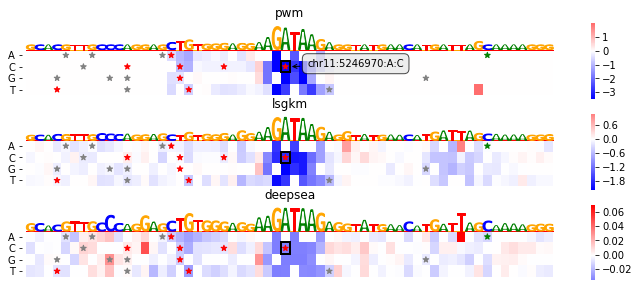

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(12,6.4))
gs = gridspec.GridSpec(4,1, hspace=0.2, wspace=0.1)


for i, model in enumerate(model_mms):
    ax = plt.subplot(gs[i, 0])
    model_mms[model].plot_mutmap(0,"seq", "diff", sel_model_outputs[model], 
                                   ax = ax, limit_region_genomic = region_limits[0], 
                                   minimum_letter_height = 0.2,show_var_id=i==0)
    plt.scatter(clinvar_elms["x"], clinvar_elms["y"]-0.5, c=clinvar_elms["color"], marker="*")
    ax.set_title(model)

plt.show()
plt.savefig(output_path + "fig4e.pdf")